# Effect of automation on complexity behavior

## Setup

In [ ]:
import process_simulation
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm.notebook import tqdm  # Progress bar for Jupyter Notebooks
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib.ticker import FuncFormatter

## Perform and plot simulations for exploratory analysis

In [308]:
# set configuration for non-automated process, no exceptions
t = 5000 # number of iterations (5000 default)
l = 100 # lexicon: number of different process steps
m = 5 # number of subunits of the process, needs to be a factor of l
r = 50 # number of historic sequences remembered
n = 5

# set variability metrics
v_m = 0.005
v_a = 0
v_m_e = 0.01
v_a_e = 0.03

# set automation degree and exception percentage 
a = 0
e = 0

# set the seed to an integer value for reproducibility
seed = 2

simulation_models = {}

simulation_models['No Automation, No Exceptions'] = process_simulation.ProcessSimulationModel(t, l, m, r, n, v_m=v_m, v_a=v_a, v_m_e=v_m_e, v_a_e=v_a_e, a=a, e=e, seed=seed)
a = 0.5
simulation_models['Partial automation, No Exceptions'] = process_simulation.ProcessSimulationModel(t, l, m, r, n, v_m=v_m, v_a=v_a, v_m_e=v_m_e, v_a_e=v_a_e, a=a, e=e, seed=seed)
e = 0.1
a = 0
simulation_models['No automation, Exceptions'] = process_simulation.ProcessSimulationModel(t, l, m, r, n, v_m=v_m, v_a=v_a, v_m_e=v_m_e, v_a_e=v_a_e, a=a, e=e, seed=seed)
a = 0.5
simulation_models['Partial Automation, Exceptions'] = process_simulation.ProcessSimulationModel(t, l, m, r, n, v_m=v_m, v_a=v_a, v_m_e=v_m_e, v_a_e=v_a_e, a=a, e=e, seed=seed)

In [309]:
# run all simulations
simulation_ams_dict = {sim_name: simulation.run_simulation() for sim_name, simulation in simulation_models.items()}
simluation_metrics_over_time_dict = {sim_name: process_simulation.get_metrics_for_sim_results(sim_ams, metrics=['number of connected nodes', 'number of edges', 'density', 'avg degree', 'est. count simple paths']) for sim_name, sim_ams in simulation_ams_dict.items()}

# Initialize the MinMaxScaler
def norm_df(df):
    normed_df = pd.DataFrame()

    # normalize all complexity metrics to plot them in one graph and observe their differences
    def absolute_maximum_scale(series):
        return series / series.abs().max()
    for col in df.columns:
        normed_df[col] = absolute_maximum_scale(df[col])
    return normed_df

norm_simluation_metrics_over_time_dict = {sim_name: norm_df(simluation_metrics_over_time) for sim_name, simluation_metrics_over_time in simluation_metrics_over_time_dict.items()}

simulation_metrics_summary_dict = {sim_name: process_simulation.get_aggregate_sim_result(sim_ams) for sim_name, sim_ams in simulation_ams_dict.items()}

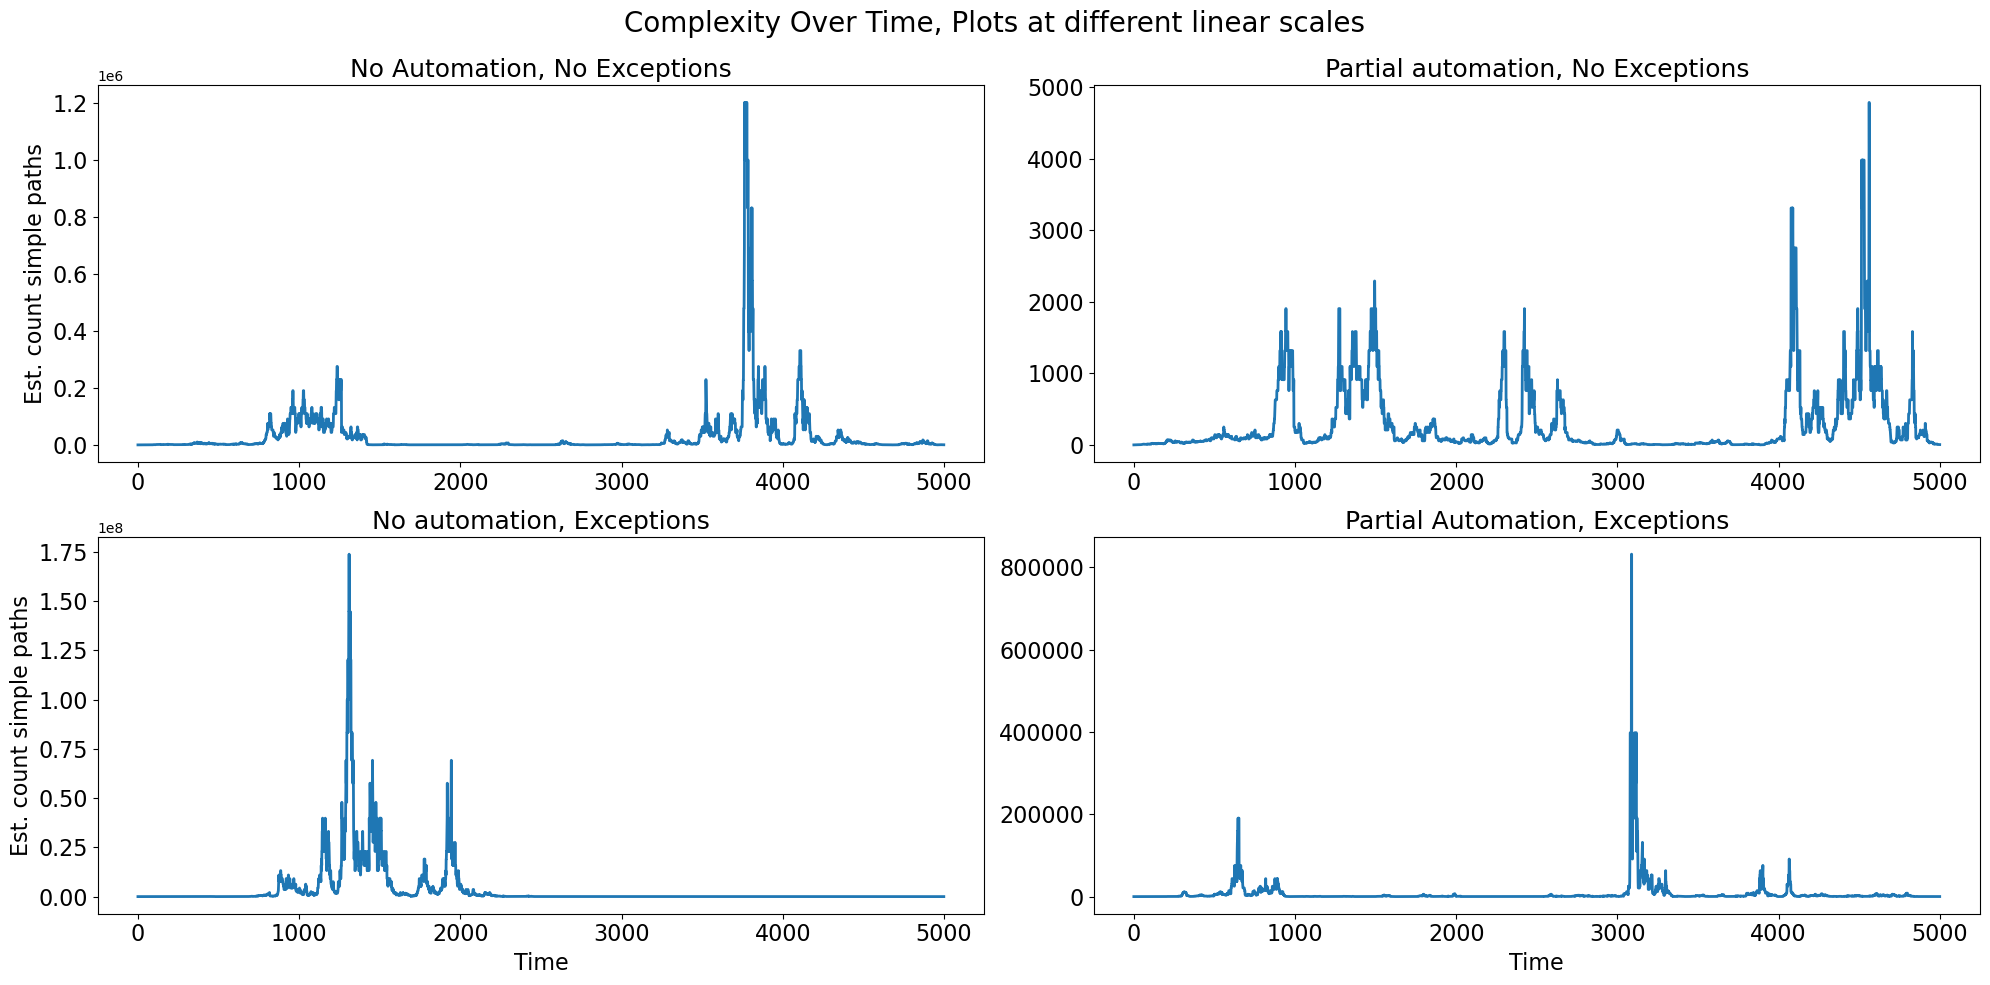

In [310]:
# print complexity over time
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Complexity Over Time, Plots at different linear scales', fontsize=20)

# Flatten the axs array for easier iteration
axs = axs.flatten()

for i, (ax, (sim_name, metrics)) in enumerate(zip(axs, simluation_metrics_over_time_dict.items())):
    metrics[['est. count simple paths']].plot(ax=ax, title=sim_name, fontsize=16, linewidth=2)
    ax.set_title(sim_name, fontsize=18)
    if i % 2 == 0:
        ax.set_ylabel("Est. count simple paths", fontsize=16)
    if i >= 2:
        ax.set_xlabel("Time", fontsize=16)
    else:
        ax.set_xlabel("")
    ax.get_legend().remove()

# Add a legend box below the graph
lines, labels = axs[0].get_legend_handles_labels()

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig('experiment_results/plot_complexity_subplots.pdf', dpi=300, bbox_inches='tight')
plt.show()

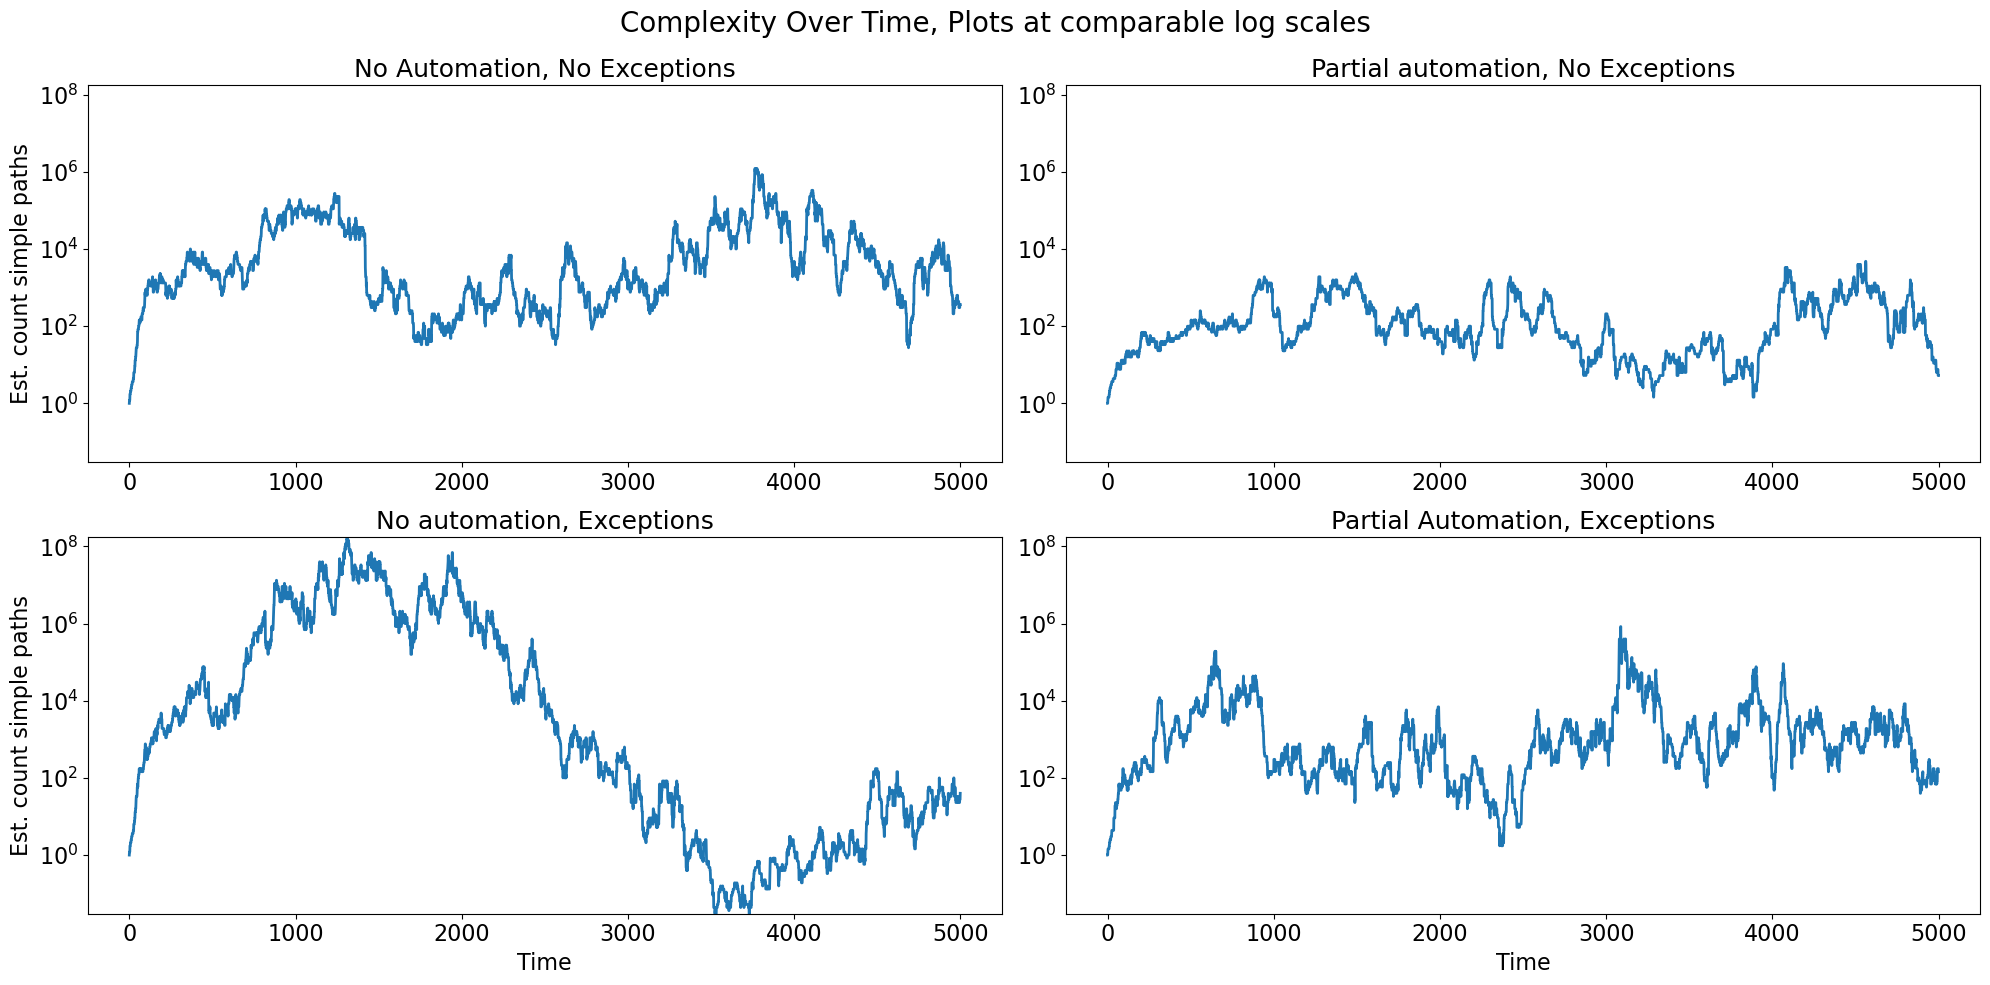

In [311]:
# print complexity over time
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Complexity Over Time, Plots at comparable log scales', fontsize=20)

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Determine the common y-axis limits
y_min = min(metrics['est. count simple paths'].min() for metrics in simluation_metrics_over_time_dict.values())
y_max = max(metrics['est. count simple paths'].max() for metrics in simluation_metrics_over_time_dict.values())

for i, (ax, (sim_name, metrics)) in enumerate(zip(axs, simluation_metrics_over_time_dict.items())):
    metrics[['est. count simple paths']].plot(ax=ax, title=sim_name, fontsize=16, linewidth=2)
    ax.set_yscale('log')
    ax.set_ylim(y_min, y_max)
    ax.set_title(sim_name, fontsize=18)
    if i % 2 == 0:
        ax.set_ylabel("Est. count simple paths", fontsize=16)
    if i >= 2:
        ax.set_xlabel("Time", fontsize=16)
    else:
        ax.set_xlabel("")
    ax.get_legend().remove()

# Add a legend box below the graph
lines, labels = axs[0].get_legend_handles_labels()

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig('experiment_results/plot_complexity_subplots_log_scale.pdf', dpi=300, bbox_inches='tight')
plt.show()


Heatmaps for No Automation, No Exceptions


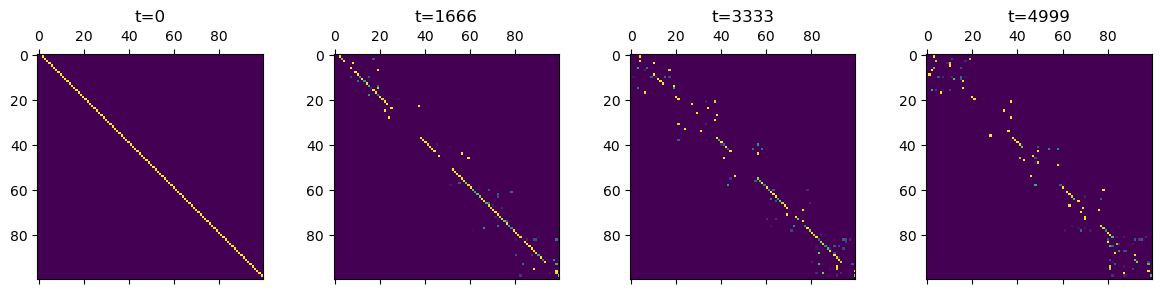

Heatmaps for Partial automation, No Exceptions


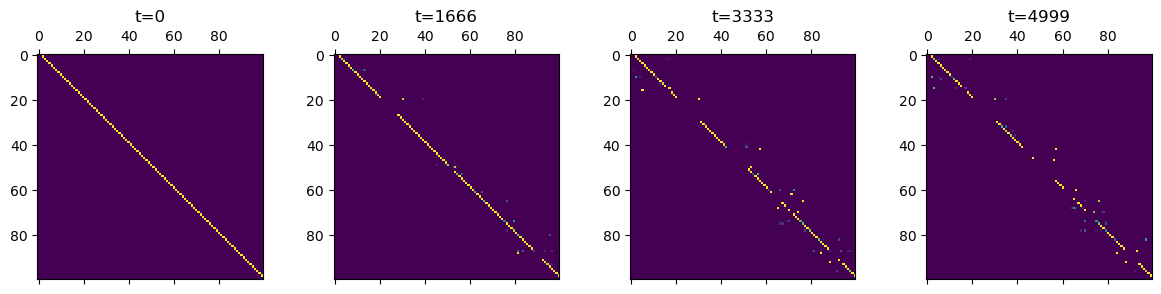

Heatmaps for No automation, Exceptions


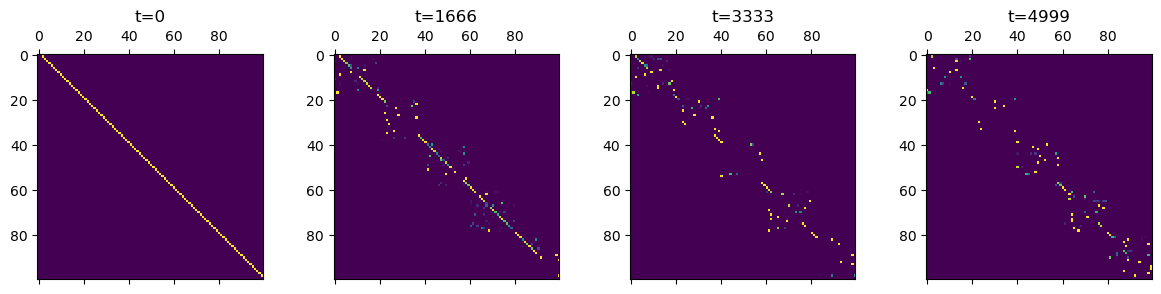

Heatmaps for Partial Automation, Exceptions


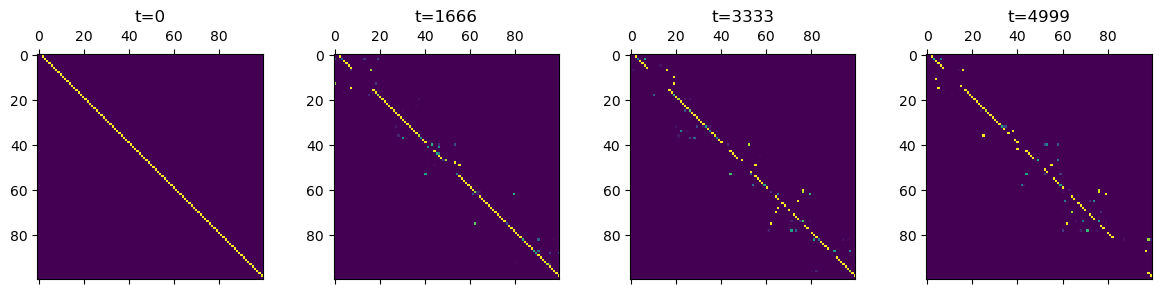

In [312]:
for sim_name, sim_ams in simulation_ams_dict.items():
    print(f"Heatmaps for {sim_name}")
    plt = process_simulation.get_heatmap_plot(sim_ams, 4, 1, title=None)
    sim_name_clean = sim_name.replace(',', '')
    sim_name_clean = sim_name_clean.replace(' ', '_')
    plt.savefig(f'experiment_results/heatmaps_{sim_name_clean}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

## Load computed simulations

## Analyze results

### Read simulation results from df

In [326]:
simulation_results_df = process_simulation.get_results_dataframe("experiment_results/simulation_results.csv")

# delete results from old version
filtered_df = simulation_results_df.loc[
    simulation_results_df['version'] == process_simulation.VERSION
]

def aggreated_results_df(df):
    # aggregate results with same parameters
    grouped_df = df.groupby(['version', 't', 'l', 'm', 'r', 'n', 'v_m', 'v_a', 'v_m_e', 'v_a_e', 'e', 'a'])

    aggregated_df = grouped_df.agg({
        'seed': 'count',
        'max_complexity': ['mean', 'median', 'max', 'std'],
        'mean_complexity': ['mean', 'median', 'max', 'std'],
        'has_phase_change': ['mean', 'median', 'max', 'std'],
        'time_to_chaos': ['mean', 'median', 'max', 'std']
    }).rename(columns={'seed': 'simulation_runs'})

    aggregated_df.rename(columns={'sim_id': 'simulation_runs'}, inplace=True)
    return aggregated_df

aggregated_df = aggreated_results_df(filtered_df)

display(aggregated_df)

simulation_runs  \
                                                                count   
version t    l   m r  n v_m   v_a v_m_e v_a_e e   a                     
0.03    5000 100 5 50 5 0.005 0   0.01  0.03  0.0 0.0             500   
                                                  0.1             500   
                                                  0.2             500   
                                                  0.3             500   
                                                  0.4             500   
...                                                               ...   
                                              0.3 0.6             500   
                                                  0.7             500   
                                                  0.8             500   
                                                  0.9             500   
                                                  1.0             500   

                                                      max_complexity  \
                                                                mean   
version t    l   m r  n v_m   v_a v_m_e v_a_e e   a                    
0.03    5000 100 5 50 5 0.005 0   0.01  0.03  0.0 0.0   6.991210e+12   
                                                  0.1   7.379438e+14   
                                                  0.2   1.082766e+14   
                                                  0.3   1.264420e+14   
                                                  0.4   1.163272e+11   
...                                                              ...   
                                              0.3 0.6   1.164490e+19   
                                                  0.7   2.569304e+15   
                                                  0.8   9.457596e+14   
                                                  0.9   2.637194e+18   
                                                  1.0   3.385339e+06   

                                                                     \
                                                             median   
version t    l   m r  n v_m   v_a v_m_e v_a_e e   a                   
0.03    5000 100 5 50 5 0.005 0   0.01  0.03  0.0 0.0  8.317638e+07   
                                                  0.1  1.905461e+07   
                                                  0.2  3.630781e+06   
                                                  0.3  8.317638e+05   
                                                  0.4  2.290868e+05   
...                                                             ...   
                                              0.3 0.6  2.089296e+08   
                                                  0.7  4.383686e+07   
                                                  0.8  2.754229e+07   
                                                  0.9  7.585776e+06   
                                                  1.0  1.737801e+06   

                                                                     \
                                                                max   
version t    l   m r  n v_m   v_a v_m_e v_a_e e   a                   
0.03    5000 100 5 50 5 0.005 0   0.01  0.03  0.0 0.0  1.318257e+15   
                                                  0.1  1.584893e+17   
                                                  0.2  5.248075e+16   
                                                  0.3  6.309573e+16   
                                                  0.4  5.754399e+13   
...                                                             ...   
                                              0.3 0.6  5.754399e+21   
                                                  0.7  1.000000e+18   
                                                  0.8  3.981072e+17   
                                                  0.9  1.318257e+21   
                                                  1.0  8.317638e+07   

                                

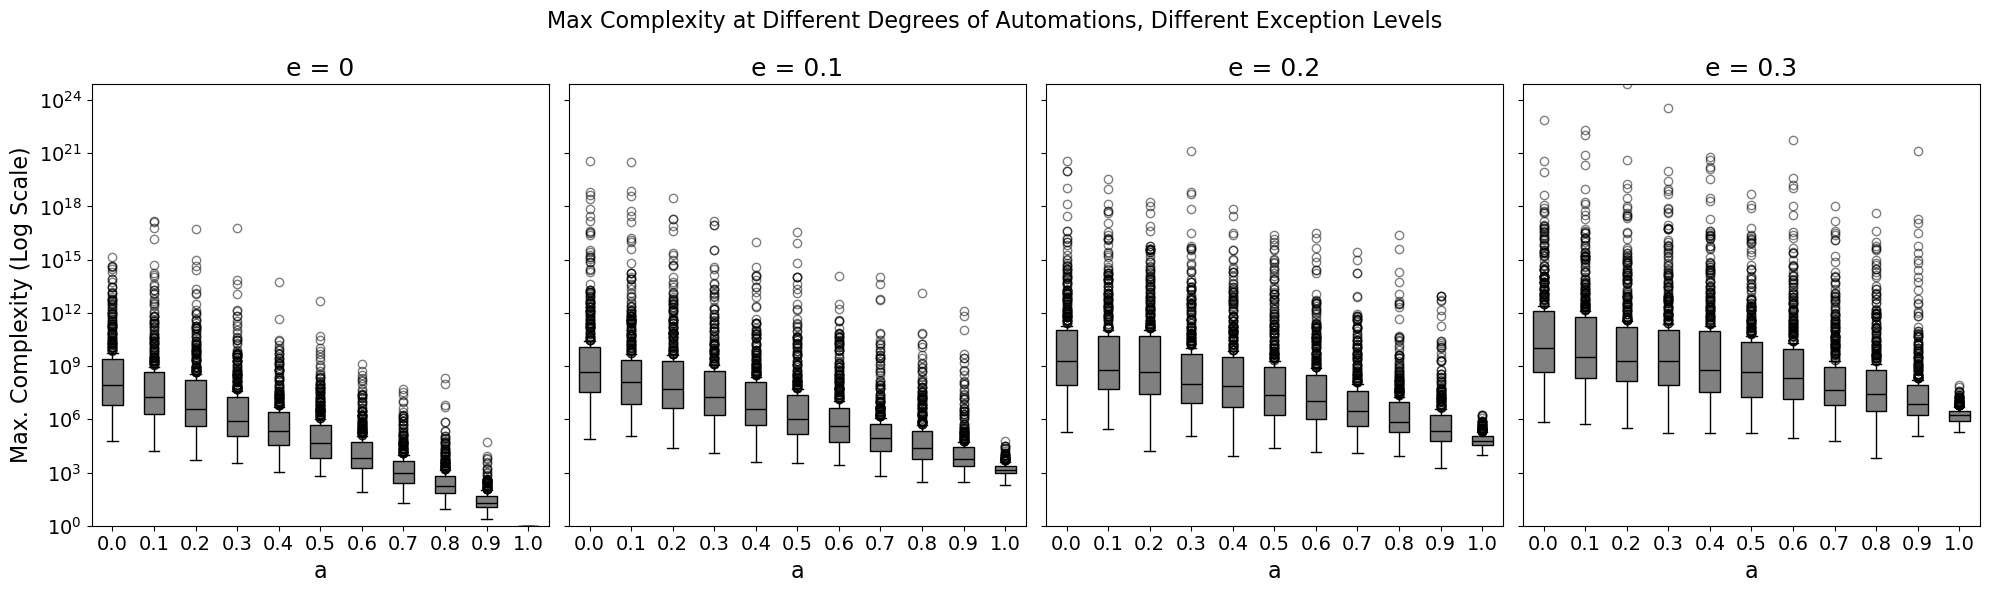

In [314]:
fig, axs = plt.subplots(1, 4, figsize=(20, 6))

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Define the exception levels to plot
exception_levels = [0, 0.1, 0.2, 0.3]

# Determine the common y-axis limits
y_min = filtered_df['max_complexity'].min()
y_max = filtered_df['max_complexity'].max()

for ax, e_level in zip(axs, exception_levels):
    automation_no_exceptions = filtered_df.loc[filtered_df['e'] == e_level]
    automation_no_exceptions.boxplot(column='max_complexity', by='a', grid=False, ax=ax, patch_artist=True, boxprops=dict(facecolor='grey', color='black'), medianprops=dict(color='black'), whiskerprops=dict(color='black'), capprops=dict(color='black'), flierprops=dict(marker='o', color='black', alpha=0.5))
    ax.set_yscale('log')
    ax.set_ylim(y_min, y_max)
    ax.set_title(f'e = {e_level}', fontsize=18)
    ax.set_xlabel('a', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)  # Increase tick label size
    if e_level == 0:
        ax.set_ylabel('Max. Complexity (Log Scale)', fontsize=16)
    else:
        ax.set_yticklabels([])  # Hide y-axis tick labels for other subplots
    plt.suptitle('')  # Suppress the default title to avoid duplication

fig.suptitle('Max Complexity at Different Degrees of Automations, Different Exception Levels', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

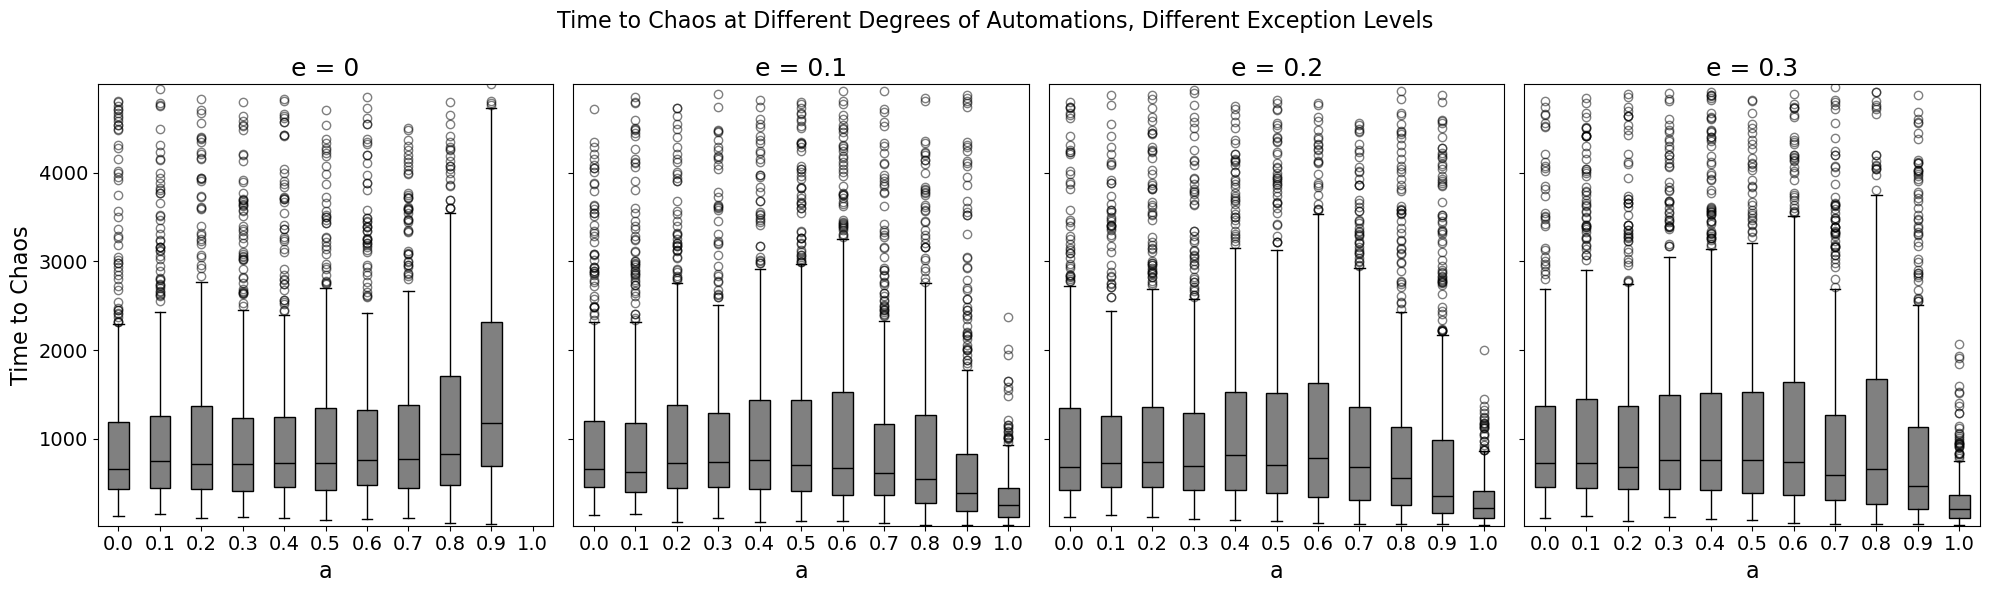

In [315]:
fig, axs = plt.subplots(1, 4, figsize=(20, 6))

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Define the exception levels to plot
exception_levels = [0, 0.1, 0.2, 0.3]

# Determine the common y-axis limits
y_min = filtered_df['time_to_chaos'].min()
y_max = filtered_df['time_to_chaos'].max()

for ax, e_level in zip(axs, exception_levels):
    automation_no_exceptions = filtered_df.loc[filtered_df['e'] == e_level]
    boxplot = automation_no_exceptions.boxplot(column='time_to_chaos', by='a', grid=False, ax=ax, patch_artist=True, boxprops=dict(facecolor='grey', color='black'), medianprops=dict(color='black'), whiskerprops=dict(color='black'), capprops=dict(color='black'), flierprops=dict(marker='o', color='black', alpha=0.5))
    ax.set_ylim(y_min, y_max)
    ax.set_title(f'e = {e_level}', fontsize=18)
    ax.set_xlabel('a', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)  # Increase tick label size
    if e_level == 0:
        ax.set_ylabel('Time to Chaos', fontsize=16)
    else:
        ax.set_yticklabels([])  # Hide y-axis tick labels for other subplots
    plt.suptitle('')  # Suppress the default title to avoid duplication

fig.suptitle('Time to Chaos at Different Degrees of Automations, Different Exception Levels', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

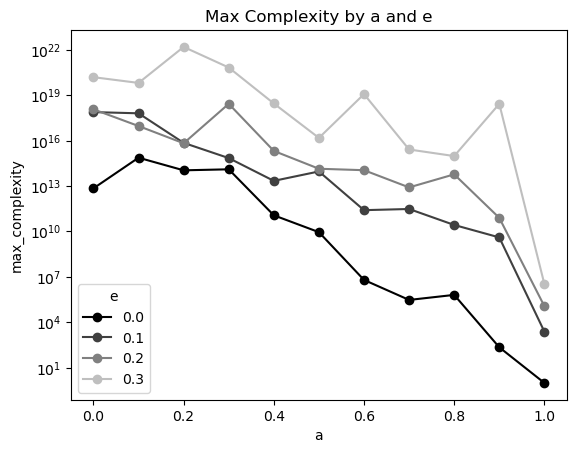

In [316]:
flat_aggregated_df = aggregated_df.reset_index()

filtered_df = flat_aggregated_df.loc[flat_aggregated_df['e'].isin([0, 0.1, 0.2, 0.3])]

# Create a pivot table to reshape the data for plotting
pivot_df = filtered_df.pivot(index='a', columns='e', values=('max_complexity', 'mean'))

# Sort the columns by 'e'
pivot_df = pivot_df.sort_index(axis=1, level=1)

# Generate grey scales for the lines
num_lines = len(pivot_df.columns)
colors = [str(i / float(num_lines)) for i in range(num_lines)]

# Plot the data
ax = pivot_df.plot(kind='line', marker='o', color=colors)

# Set the y-axis to logarithmic scale
ax.set_yscale('log')

# Add labels and title
plt.xlabel('a')
plt.ylabel('max_complexity')
plt.title('Max Complexity by a and e')
plt.legend(title='e')

# Show the plot
plt.show()

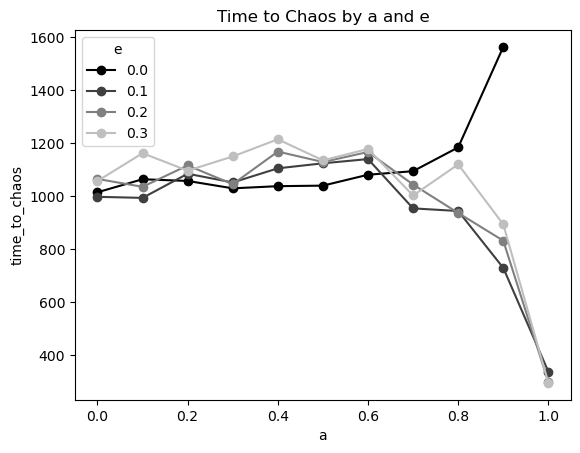

In [317]:
flat_aggregated_df = aggregated_df.reset_index()

filtered_df = flat_aggregated_df.loc[flat_aggregated_df['e'].isin([0, 0.1, 0.2, 0.3])]

# Create a pivot table to reshape the data for plotting
pivot_df = filtered_df.pivot(index='a', columns='e', values=('time_to_chaos', 'mean'))

# Sort the columns by 'e'
pivot_df = pivot_df.sort_index(axis=1, level=1)

# Generate grey scales for the lines
num_lines = len(pivot_df.columns)
colors = [str(i / float(num_lines)) for i in range(num_lines)]

# Plot the data
ax = pivot_df.plot(kind='line', marker='o', color=colors)

# Set the y-axis to logarithmic scale
# ax.set_yscale('log')

# Add labels and title
plt.xlabel('a')
plt.ylabel('time_to_chaos')
plt.title('Time to Chaos by a and e')
plt.legend(title='e')

# Show the plot
plt.show()

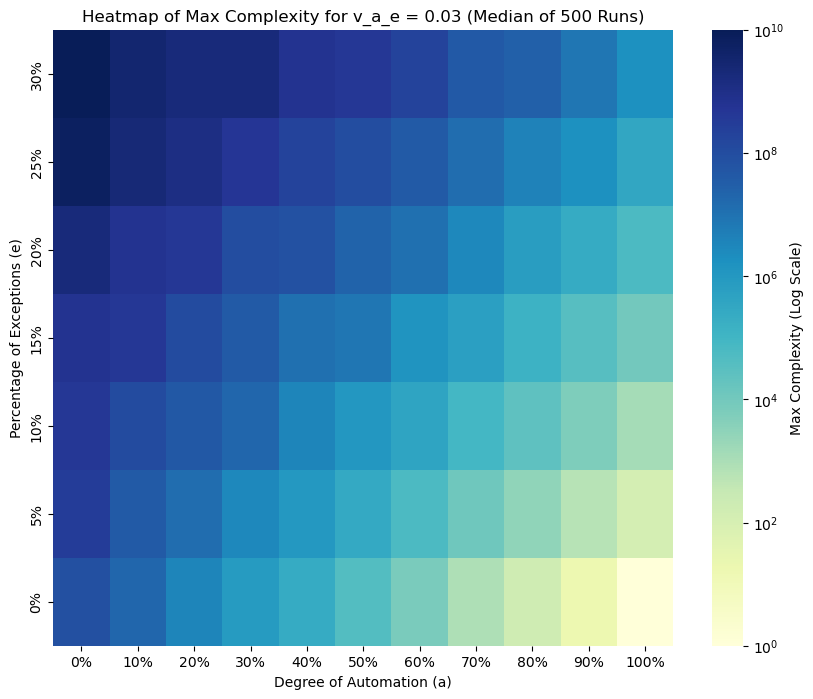

In [330]:
def create_heatmap(df, runs, v_a_e=None):
    # Reset the index to flatten the multi-index columns
    flat_aggregated_df = df.reset_index(inplace=False)

    filtered_aggregated_df = flat_aggregated_df
    if v_a_e is not None:
        filtered_aggregated_df = flat_aggregated_df[flat_aggregated_df['v_a_e'] == v_a_e]

    # Pivot the dataframe to get the desired shape for the heatmap
    heatmap_data = filtered_aggregated_df.pivot(index='e', columns='a', values=('max_complexity', 'median')).sort_index(ascending=False)

    # Create the heatmap with logarithmic color scale
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(heatmap_data, annot=False, cmap="YlGnBu", norm=LogNorm(), cbar_kws={'label': 'Max Complexity (Log Scale)'})

    # Format the x and y axis as percentages
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

    # Set the correct tick positions
    ax.set_xticks([i + 0.5 for i in range(len(heatmap_data.columns))])
    ax.set_yticks([i + 0.5 for i in range(len(heatmap_data.index))])

    # Set the correct tick labels
    ax.set_xticklabels([f'{int(a*100)}%' for a in heatmap_data.columns])
    ax.set_yticklabels([f'{int(e*100)}%' for e in heatmap_data.index])

    if v_a_e is None:
        plt.title(f'Heatmap of Max Complexity (Median of {runs} Runs)')
    else:
        plt.title(f'Heatmap of Max Complexity for v_a_e = {v_a_e} (Median of {runs} Runs)')
    plt.xlabel('Degree of Automation (a)')
    plt.ylabel('Percentage of Exceptions (e)')
    plt.show()

create_heatmap(aggregated_df, 500, v_a_e=0.03)

In [331]:
simulation_results_df = process_simulation.get_results_dataframe("results_v_a_e_variation.csv")

# delete results from old version
filtered_df = simulation_results_df.loc[
    simulation_results_df['version'] == process_simulation.VERSION
]

def aggreated_results_df(df):
    # aggregate results with same parameters
    grouped_df = df.groupby(['version', 't', 'l', 'm', 'r', 'n', 'v_m', 'v_a', 'v_m_e', 'v_a_e', 'e', 'a'])

    aggregated_df = grouped_df.agg({
        'seed': 'count',
        'max_complexity': ['mean', 'median', 'max', 'std'],
        'mean_complexity': ['mean', 'median', 'max', 'std'],
        'has_phase_change': ['mean', 'median', 'max', 'std'],
        'time_to_chaos': ['mean', 'median', 'max', 'std']
    }).rename(columns={'seed': 'simulation_runs'})

    aggregated_df.rename(columns={'sim_id': 'simulation_runs'}, inplace=True)
    return aggregated_df

aggregated_df = aggreated_results_df(filtered_df)

display(aggregated_df)

simulation_runs  \
                                                                count   
version t    l   m r  n v_m   v_a v_m_e v_a_e e   a                     
0.03    5000 100 5 50 5 0.005 0   0.01  0.03  0.0 0.0              12   
                                                  0.1              10   
                                                  0.2              11   
                                                  0.3              11   
                                                  0.4              12   
...                                                               ...   
                                        0.20  0.3 0.6              14   
                                                  0.7              15   
                                                  0.8              15   
                                                  0.9              11   
                                                  1.0              11   

                                                      max_complexity  \
                                                                mean   
version t    l   m r  n v_m   v_a v_m_e v_a_e e   a                    
0.03    5000 100 5 50 5 0.005 0   0.01  0.03  0.0 0.0   7.046107e+10   
                                                  0.1   1.113324e+11   
                                                  0.2   4.715435e+08   
                                                  0.3   2.205969e+06   
                                                  0.4   1.010111e+08   
...                                                              ...   
                                        0.20  0.3 0.6   6.541764e+29   
                                                  0.7   1.270690e+36   
                                                  0.8   2.356510e+39   
                                                  0.9   4.351555e+40   
                                                  1.0   6.857548e+38   

                                                                     \
                                                             median   
version t    l   m r  n v_m   v_a v_m_e v_a_e e   a                   
0.03    5000 100 5 50 5 0.005 0   0.01  0.03  0.0 0.0  6.990536e+07   
                                                  0.1  1.905461e+07   
                                                  0.2  9.120108e+06   
                                                  0.3  3.311311e+05   
                                                  0.4  3.367650e+05   
...                                                             ...   
                                        0.20  0.3 0.6  2.941390e+23   
                                                  0.7  2.290868e+27   
                                                  0.8  3.019952e+28   
                                                  0.9  1.737801e+34   
                                                  1.0  1.445440e+36   

                                                                     \
                                                                max   
version t    l   m r  n v_m   v_a v_m_e v_a_e e   a                   
0.03    5000 100 5 50 5 0.005 0   0.01  0.03  0.0 0.0  8.317638e+11   
                                                  0.1  6.918310e+11   
                                                  0.2  2.290868e+09   
                                                  0.3  1.905461e+07   
                                                  0.4  1.096478e+09   
...                                                             ...   
                                        0.20  0.3 0.6  9.120108e+30   
                                                  0.7  1.905461e+37   
                                                  0.8  2.089296e+40   
                                                  0.9  4.786301e+41   
                                                  1.0  3.981072e+39   

                                

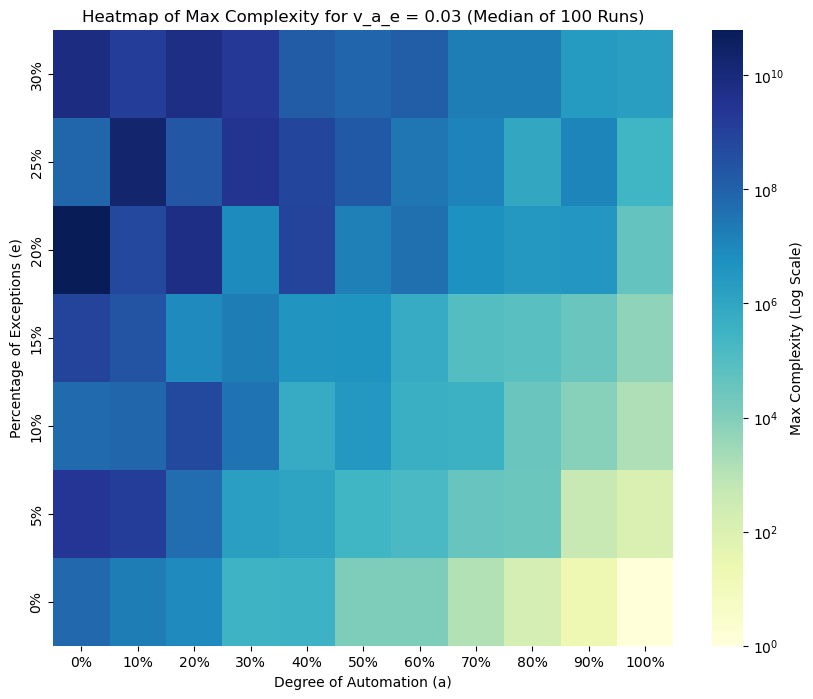

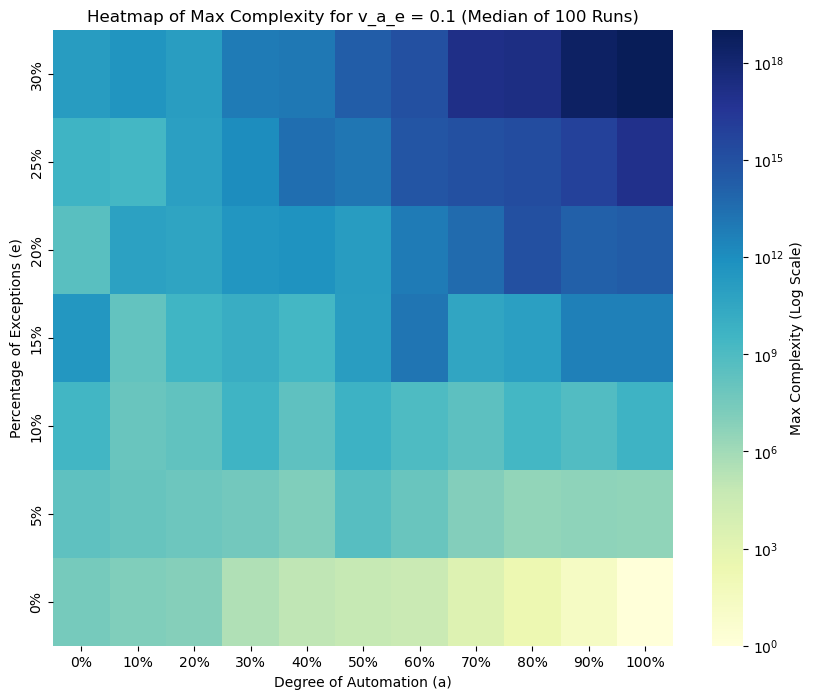

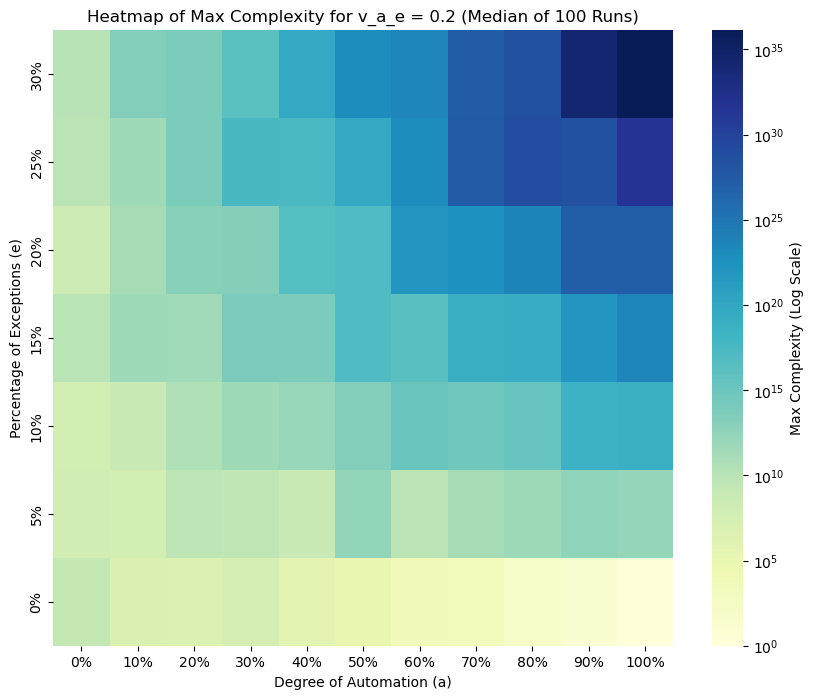

In [332]:
create_heatmap(aggregated_df, 100, v_a_e=0.03)
create_heatmap(aggregated_df, 100, v_a_e=0.1)
create_heatmap(aggregated_df, 100, v_a_e=0.2)

In [ ]:
# estimation of turning point for ideal degree of automation
def p_jump_activity(a, e, v_a, v_m, v_a_e, v_m_e):
    return a * (1 - e) * v_a + (1 - a) * (1-e) * v_m + a * e * v_a_e + (1 - a) * e * v_m_e

# exceptions are given
# v_a_e is given
# what would be a (the ideal degree of automation)

avg_remembered_jumps = l * r * p_jump_activity(a, e, v_a, v_m, 0.05, v_m_e)
avg_remembered_jumps

116.25000000000001

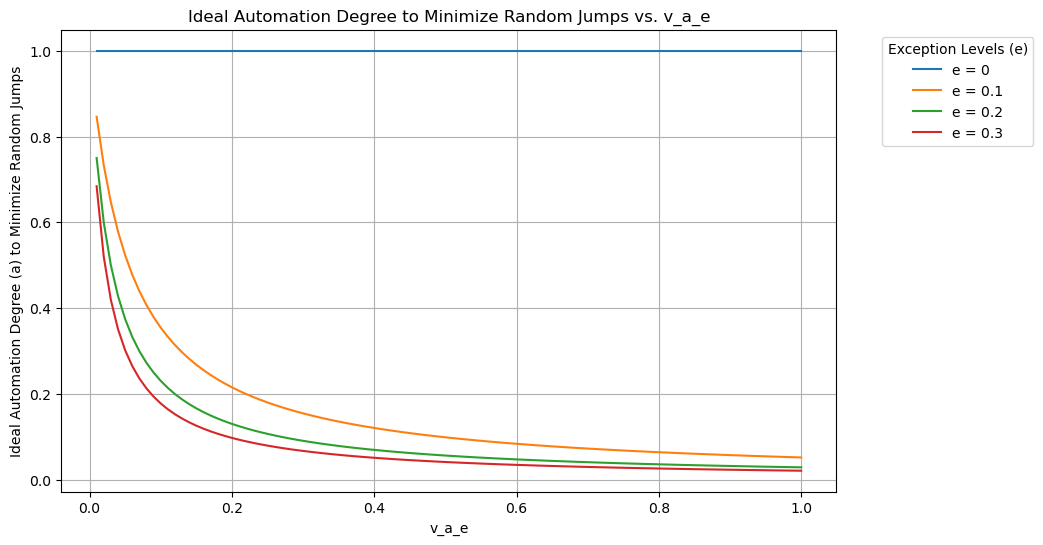

In [ ]:
import numpy as np

def get_ideal_automation_degree(e, v_a, v_m, v_a_e, v_m_e):
    return ((1 - e) * v_m + e * v_m_e) / ((1 - e) * v_a + e * v_a_e + (1 - e) * v_m + e * v_m_e)

# Define the range of v_a_e values
v_a_e_values = np.linspace(0.01, 1, 100)

# Calculate the ideal automation degree for each v_a_e value
e_values = [0, 0.1, 0.2, 0.3]
ideal_automation_degrees_dict = {e: [get_ideal_automation_degree(e=e, v_a=0, v_m=0.005, v_a_e=v_a_e, v_m_e=0.01) for v_a_e in v_a_e_values] for e in e_values}

# Plot the results
plt.figure(figsize=(10, 6))
for e, ideal_automation_degrees in ideal_automation_degrees_dict.items():
    plt.plot(v_a_e_values, ideal_automation_degrees, label=f'e = {e}')
plt.xlabel('v_a_e')
plt.ylabel('Ideal Automation Degree (a) to Minimize Random Jumps')
plt.title('Ideal Automation Degree to Minimize Random Jumps vs. v_a_e')
plt.grid(True)
plt.legend(title='Exception Levels (e)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Comparisson of Complexity metrics

In [ ]:
f = plt.figure()
ax = results_df_norm.plot(title="Complexity Over Time, Different Measures")
ax.set_ylabel("normalized complexity measure")
legend = plt.legend(title='Complexity Measure', bbox_to_anchor=(1.0, 1.0))
legend_frame = legend.get_frame()
legend_frame.set_facecolor('white')

plt.savefig('experiment_results/plot_complexity_measures.png', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

NameError: name 'results_df_norm' is not defined

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='time'>

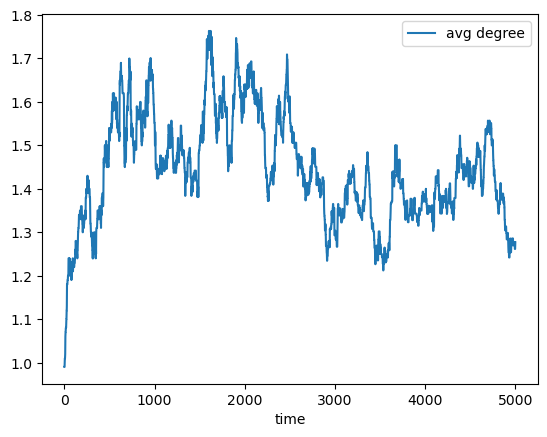

In [ ]:
results_df.plot(y='avg degree')

<Axes: xlabel='time'>

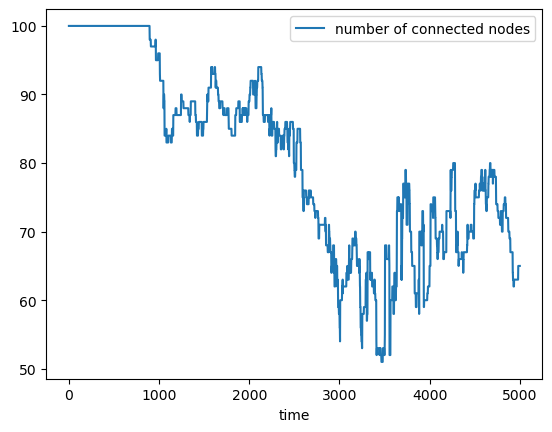

In [ ]:
results_df.plot(y='number of connected nodes')

## Plot some graphs at different times    

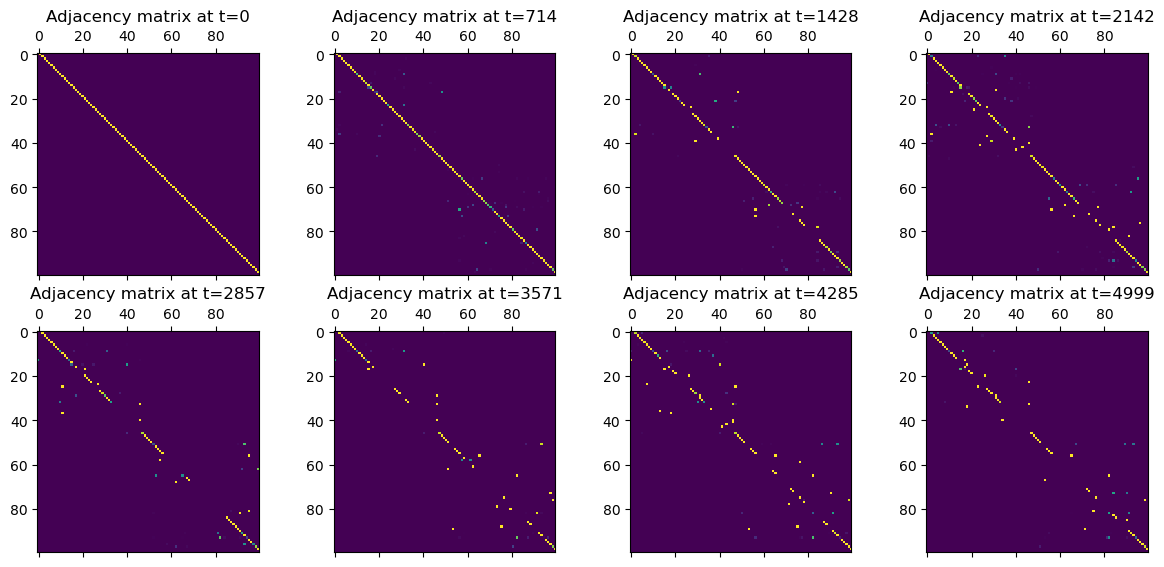

In [ ]:
process_simulation.visualize_adjacency_matrices(adjacency_matrices, 4, 2, title=None)

In [ ]:
# get metrics for simulation that can be compared to Pentland
aggregate_sim_result = process_simulation.get_aggregate_sim_result(adjacency_matrices, l)
aggregate_sim_result

{'max_complexity': 1318.25673855641,
 'mean_complexity': np.float64(105.54255655232866),
 'has_phase_change': True,
 'time_to_chaos': np.int64(487)}

## Load computed simulations

In [ ]:
# get all simulations results as dataframe
output_file = 'experiment_results/simulation_results.csv'
simulation_results_df = process_simulation.get_results_dataframe(output_file)

## Analyze results

### Read simulation results from df

In [ ]:
one_result_per_line_df = simulation_results_df

# delete results from old version
filtered_df = one_result_per_line_df.loc[
    one_result_per_line_df['version'] == process_simulation.VERSION
]

# aggregate results with same parameters
grouped_df = filtered_df.groupby(['version', 't', 'l', 'm', 'r', 'n', 'v_m', 'v_a', 'v_m_e', 'v_a_e', 'e', 'a'])

aggregated_df = grouped_df.agg({
    'seed': 'count',
    'max_complexity': ['mean', 'max', 'std'],
    'mean_complexity': ['mean', 'max', 'std'],
    'has_phase_change': ['mean', 'max', 'std'],
    'time_to_chaos': ['mean', 'max', 'std']
}).rename(columns={'seed': 'simulation_runs'})

aggregated_df.rename(columns={'sim_id': 'simulation_runs'}, inplace=True)

display(aggregated_df)

simulation_runs  \
                                                                 count   
version t    l   m r  n v_m   v_a v_m_e v_a_e e    a                     
0.02    5000 100 5 50 5 0.005 0   0.01  0.03  0.00 0.0             100   
                                                   0.1             100   
                                                   0.2             100   
                                              0.05 0.0             100   
                                                   0.1             100   
                                                   0.2             100   
                                              0.10 0.0             100   
                                                   0.1             100   
                                                   0.2              88   
                                              0.15 0.0             100   
                                                   0.1             100   
                                              0.20 0.0             100   
                                                   0.1             100   
                                              0.25 0.0             100   
                                                   0.1             100   
                                              0.30 0.0             100   
                                                   0.1             100   

                                                       max_complexity  \
                                                                 mean   
version t    l   m r  n v_m   v_a v_m_e v_a_e e    a                    
0.02    5000 100 5 50 5 0.005 0   0.01  0.03  0.00 0.0   5.599706e+13   
                                                   0.1   5.329124e+10   
                                                   0.2   6.434892e+10   
                                              0.05 0.0   2.120483e+16   
                                                   0.1   1.199163e+15   
                                                   0.2   5.231029e+10   
                                              0.10 0.0   2.128413e+15   
                                                   0.1   3.105695e+14   
                                                   0.2   1.263113e+13   
                                              0.15 0.0   7.784592e+14   
                                                   0.1   4.828896e+12   
                                              0.20 0.0   1.318372e+19   
                                                   0.1   2.205042e+14   
                                              0.25 0.0   3.981237e+21   
                                                   0.1   9.138145e+16   
                                              0.30 0.0   2.512347e+20   
                                                   0.1   2.224360e+17   

                                                                      \
                                                                 max   
version t    l   m r  n v_m   v_a v_m_e v_a_e e    a                   
0.02    5000 100 5 50 5 0.005 0   0.01  0.03  0.00 0.0  2.754229e+15   
                                                   0.1  3.019952e+12   
                                                   0.2  5.248075e+12   
                                              0.05 0.0  2.089296e+18   
                                                   0.1  1.096478e+17   
                                                   0.2  2.089296e+12   
                                              0.10 0.0  1.584893e+17   
                                                   0.1  3.019952e+16   
                                                   0.2  1.096478e+15   
                                              0.15 0.0  3.630781e+16   
                                                   0.1  4.365158e+14   
                                              0.20 0.0  1.318257e+21   
                                 

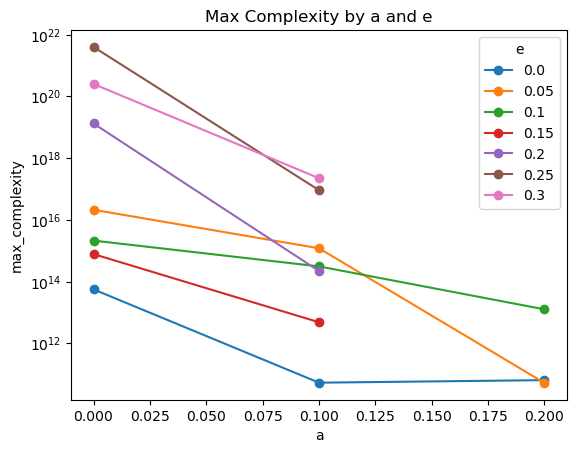

In [ ]:
flat_aggregated_df = aggregated_df.reset_index()

# plot max complexity

# Create a pivot table to reshape the data for plotting
pivot_df = flat_aggregated_df.pivot(index='a', columns='e', values=('max_complexity', 'mean'))

# Plot the data
ax = pivot_df.plot(kind='line', marker='o')

# Set the y-axis to logarithmic scale
ax.set_yscale('log')

# Add labels and title
plt.xlabel('a')
plt.ylabel('max_complexity')
plt.title('Max Complexity by a and e')
plt.legend(title='e')

# Show the plot
plt.show()

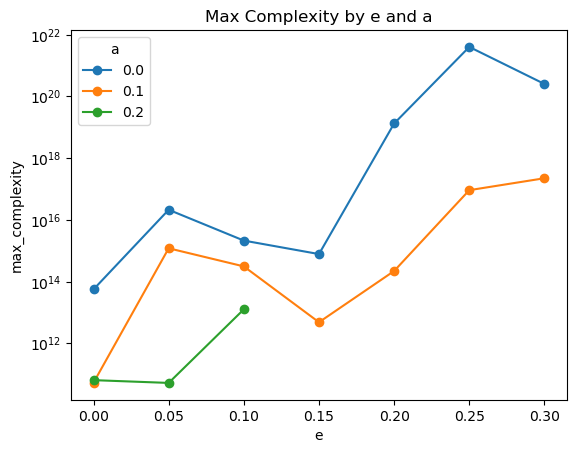

In [ ]:
flat_aggregated_df = aggregated_df.reset_index()

# plot max complexity

# Create a pivot table to reshape the data for plotting
pivot_df = flat_aggregated_df.pivot(index='e', columns='a', values=('max_complexity', 'mean'))

# Plot the data
ax = pivot_df.plot(kind='line', marker='o')

# Set the y-axis to logarithmic scale
ax.set_yscale('log')

# Add labels and title
plt.xlabel('e')
plt.ylabel('max_complexity')
plt.title('Max Complexity by e and a')
plt.legend(title='a')

# Show the plot
plt.show()

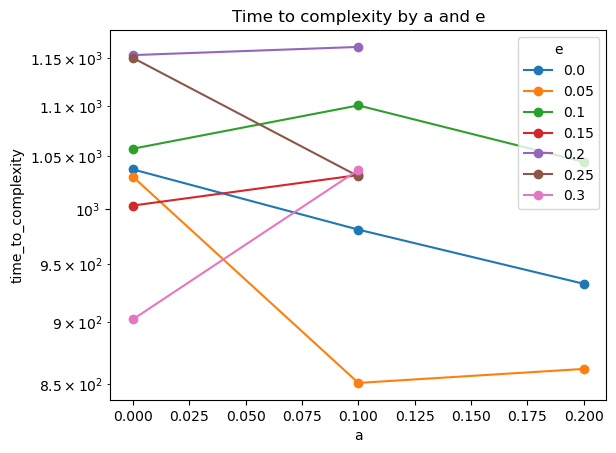

In [ ]:

# plot time to complexity

# Create a pivot table to reshape the data for plotting
pivoted_flat_df = flat_aggregated_df.pivot(index='a', columns='e', values=('time_to_chaos', 'mean'))

# Plot the data
ax = pivoted_flat_df.plot(kind='line', marker='o')

# Set the y-axis to logarithmic scale
ax.set_yscale('log')

# Add labels and title
plt.xlabel('a')
plt.ylabel('time_to_complexity')
plt.title('Time to complexity by a and e')
plt.legend(title='e')

# Show the plot
plt.show()